**Integrantes**:
* Adolfo Patricio Barrero Olguín - 418046100
* Néstor Iván Martínez Ostoa - 315618648
* Jorge Alejandro Ramírez Bondi - 314634825

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing as HoltWinters
from sklearn.metrics import mean_absolute_error

In [36]:
consumer = pd.read_csv('https://tinyurl.com/y5az8zct', index_col=['DATE'],parse_dates=['DATE'])
consumer.head()

,CPIAUCSL
DATE,
1947-01-01,21.48
1947-02-01,21.62
1947-03-01,22.00
1947-04-01,22.00
1947-05-01,21.95


# Media Móvil

In [37]:
def plotMovingAverage(series, window, plot_intervals=False,
                      scale=1.96, plot_anomalies=False):
    rolling_mean = series.rolling(window=window).mean()
    plt.figure(figsize=(15, 5))
    plt.title('Media móvil \ntamaño de ventana = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Tendencia por media móvil')
    # Intervalos de confianza
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(lower_bound, 'r--', label='Límites sup/inf')
        plt.plot(upper_bound, 'r--')
        # Anomalías
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series < lower_bound] = series[series < lower_bound]
            anomalies[series > upper_bound] = series[series > upper_bound]
            plt.plot(anomalies, 'ro', markersize=10)
    plt.plot(series[window:], label='Valores reales')
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.show()

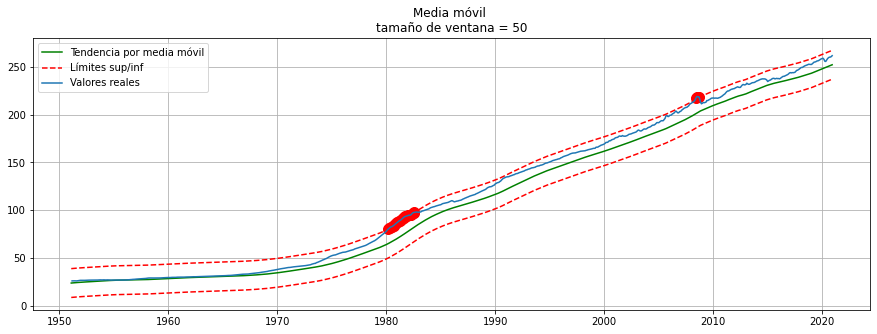

In [38]:
plotMovingAverage(consumer, 50, plot_intervals=True,plot_anomalies=True)

# Exponencial

In [39]:
def exponential_smoothing(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n - 1])
    return result


def plotExponentialSmoothing(series, alphas):
    with plt.style.context('seaborn-white'):
        plt.figure(figsize=(13, 7))
        for alpha in alphas:
            plt.plot(exponential_smoothing(series, alpha),
                     label='Alpha: {}'.format(alpha))
            plt.plot(series.values, 'c', label='Real')
            plt.legend(loc='best')
            plt.axis('tight')
            plt.title('Suaviza exponencial')
            plt.grid(True)
        plt.show()

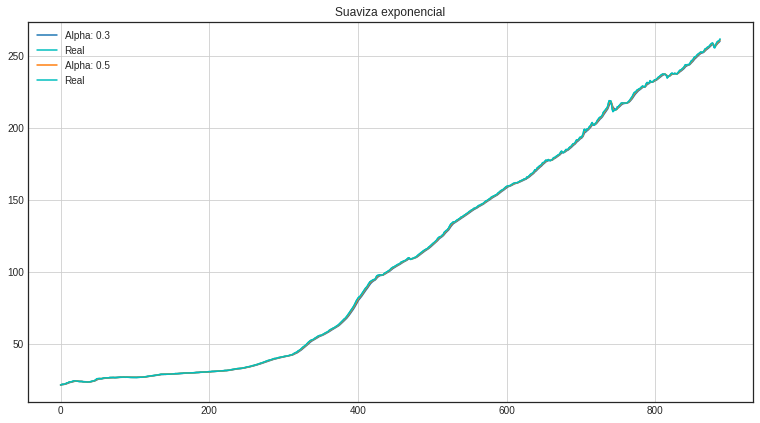

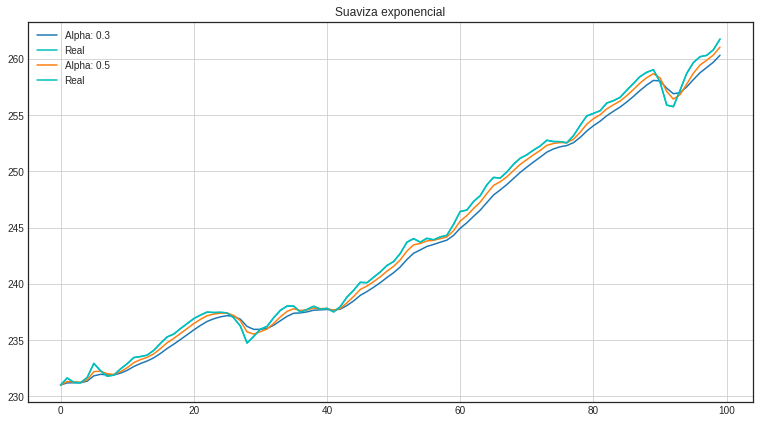

In [40]:
plotExponentialSmoothing(consumer.CPIAUCSL, [0.3, 0.5])
plotExponentialSmoothing(consumer.CPIAUCSL[-100:], [0.3, 0.5])

# Holt-Winters

In [41]:
def  plotHWSmothing(series, n=20):
    hw = HoltWinters (( series),seasonal_periods =12).fit()
    train, test = series[:-n], series[len(series)-n:]
    hw_p = hw.predict(start=test.index[0],end=test.index[-1])
    plt.figure(figsize =(12 ,6))
    plt.plot(train.index ,train ,label='Train')
    plt.plot(test.index ,test ,label='Test')
    plt.plot(hw_p.index ,hw_p ,label='H-W')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()


/home/nestor/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


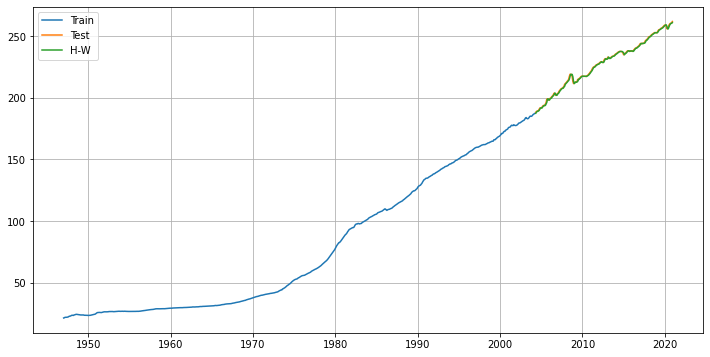

In [42]:
plotHWSmothing(consumer.CPIAUCSL, 200)

# Regresión Lineal

## Modelo lineal

In [75]:
def linear_model_lr(series):
    #Train test split
    X = np.arange(len(series['DATE']))
    y = series['CPIAUCSL'].to_numpy()
    n = (len(series['DATE']) * 3 ) // 4
    X_train, X_test, y_train, y_test = X[:n], X[n:], y[:n], y[n:]
    #Model fitting and prediction
    reg = LinearRegression().fit(np.reshape(X_train, (-1,1)),           np.array(y_train))
    y_pred = reg.predict(np.reshape(X, (-1,1)))
    #Plotting
    plt.figure(figsize =(9 ,6))
    xx = range(len(y_train), len(y_train) + len(y_test))
    plt.plot(y_train, label='y_train')
    plt.plot(xx, y_test, label='y_test')
    plt.plot(y_pred, label='y_pred')
    plt.legend(loc='best')
    plt.title('Modelo lineal')
    plt.grid()
    plt.show()

## Modelo cuadrático

In [76]:
def prep_proc(X):
    """
    Esta función recibe el vector X y regresa
    una matriz donde la columna 0 es el cuadrado
    de X y la columna 1 es X
    """
    x_2 = X**2
    return np.vstack([x_2, X]).T
prep_proc(X)

array([[     0,      0],
       [     1,      1],
       [     4,      2],
       ...,
       [783225,    885],
       [784996,    886],
       [786769,    887]])

In [77]:
def squared_model_lr(series):
    #Split into train test
    X = np.arange(len(consumer['DATE']))
    y = consumer['CPIAUCSL'].to_numpy()
    n = (len(consumer['DATE']) * 3 ) // 4
    X_train, X_test, y_train, y_test = X[:n], X[n:], y[:n], y[n:]
    XX_train = prep_proc(X_train)
    XX_test = prep_proc(X_test)
    #Model fitting and prediction
    reg = LinearRegression().fit(XX_train, np.array(y_train))
    y_pred = reg.predict(prep_proc(X))
    #Plotting
    plt.figure(figsize =(9 ,6))
    yy = range(len(y_train), len(y_train) + len(y_test))
    plt.plot(yy,y_test, label='y_test')
    plt.plot(y_train, label='y_train')
    plt.plot(y_pred, label='y_pred')
    plt.legend(loc='best')
    plt.title('Modelo cuadrático')
    plt.grid()
    plt.show()

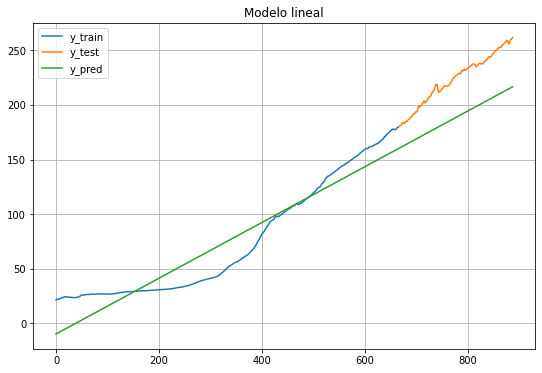

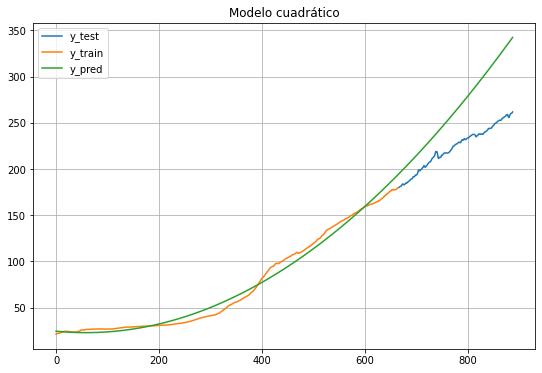

In [78]:
consumer = pd.read_csv('https://tinyurl.com/y5az8zct')
linear_model_lr(consumer)
squared_model_lr(consumer)